In [ ]:
#!pip install pandas==1.0.4
#!pip install numpy==1.18.5
#!pip install matplotlib==3.3.4
#!pip install xgboost==1.3.3
#!pip install sklearn==0.24.1

## 1 - First Glance

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

order = pd.read_csv('orders.csv.gz')
restaurant = pd.read_csv('restaurants.csv.gz') 
order

,order_acknowledged_at,order_ready_at,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
0,2015-06-01 12:28:28.952789+01:00,2015-06-01 14:12:09.474896+01:00,59.90000,1326,2,6220
1,2015-06-06 17:06:24.434807+01:00,2015-06-06 17:16:27.520253+01:00,24.00000,1326,8,603
2,2015-06-08 14:56:15.503204+01:00,2015-06-08 15:03:39.397496+01:00,15.25000,1326,3,443
3,2015-06-12 15:12:20.497925+01:00,2015-06-12 15:23:30.064683+01:00,28.05000,1326,8,669
4,2015-06-01 13:07:10.794050+01:00,2015-06-01 14:02:25.104517+01:00,56.30000,255,7,3314
...,...,...,...,...,...,...
32389,2015-06-30 21:00:29.131078+01:00,2015-06-30 21:15:42.809359+01:00,35.15000,3185,4,913
32390,2015-06-30 22:30:51.123180+02:00,2015-06-30 22:34:12.850308+02:00,9.15771,3556,3,201
32391,2015-06-30 21:50:11.585362+01:00,2015-06-30 22:04:35.205075+01:00,18.20000,3517,3,863
32392,2015-06-30 22:17:55.778938+01:00,2015-06-30 22:40:15.487549+01:00,21.50000,1705,3,1339


In [2]:
restaurant

,restaurant_id,country,city,type_of_food
0,3,UK,London,thai
1,5,UK,London,italian
2,7,UK,London,italian
3,8,UK,London,chinese
4,9,France,Paris,korean
...,...,...,...,...
1692,3594,UK,Leeds,sushi
1693,3614,France,Paris,indonesian
1694,3618,Ireland,Dublin,pan asian
1695,3620,UK,Southampton,burritos


In [3]:
print(order['order_acknowledged_at'].is_monotonic)
print(order['order_ready_at'].is_monotonic)
print(restaurant['restaurant_id'].is_monotonic)
print(f'Number of null values in order data: {order.isna().sum().sum()}')
print(f'Number of null values in restaurant data: {restaurant.isna().sum().sum()}')

False
False
True
Number of null values in order data: 0
Number of null values in restaurant data: 0


At the beginning, we can see:
* We have a little over 32K order records, and 6 features for each order
* We have a little under 1.7K restaurant records, and 4 features for each restaurant
* order data is unsorted, whereas restaurant data is sorted by restaurant_id
* order data is mostly numerical, whereas restaurant data is mostly categorical
* luckily, we don't have any unknown and missing values 

In [4]:
# Although given in the assignment description,
# it is always good idea to do sanity check for duplicates 
# (e.g. to detect an error in data preprocessing pipeline)
print(restaurant['restaurant_id'].is_unique)

True


## 2 - Exploration

,order_value_gbp,restaurant_id,number_of_items,prep_time_seconds
count,32394.000000,32394.000000,32394.000000,32394.000000
mean,26.547303,1290.555535,4.025715,1299.993857
std,19.263851,960.295504,2.392063,4404.573191
min,0.500000,3.000000,1.000000,0.000000
25%,16.700000,408.000000,3.000000,518.000000
50%,21.400000,1160.000000,3.000000,820.000000
75%,30.250000,2117.000000,5.000000,1227.000000
max,711.000000,3622.000000,38.000000,255499.000000


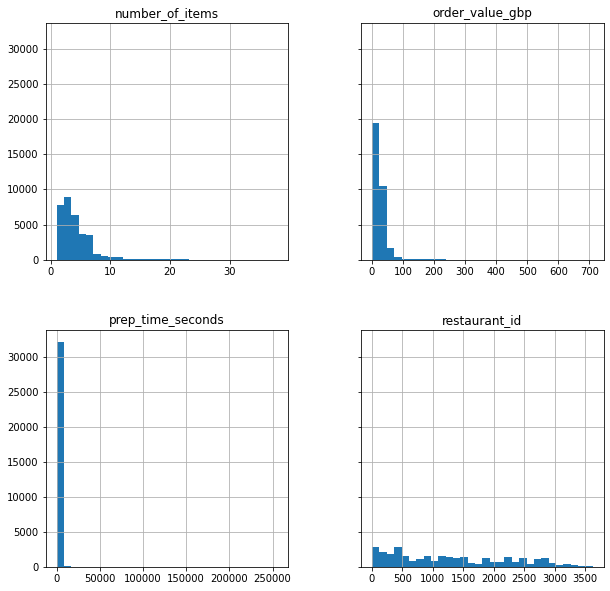

In [5]:
# Descriptive statistics and histograms for each numeric features in `order`
display(order.describe())
%matplotlib inline
hist = order.hist(bins=30, sharey=True, figsize=(10, 10))

Notice that:
* Target variable prep_time_seconds has outliers: min=0, max=255499 seconds
* Target variable prep_time_seconds has mean~=13000, median=820 seconds.
* Except for restaurant_id, all of the numeric features has positive skew, as seen by their historgam. <br>We can also arrive at this conclusion by observing that their mean values are noticeably greater than their median values.
* None of the numeric features occur in distinct buckets, so they don't need to be treated as categorical
* We might need to handle these few observations with extremely large values differently.

In [6]:
# Frequency tables for each categorical feature in restaurant
# In addition, most and least populated categories are rated
for col in restaurant.select_dtypes(include=['object']).columns:
    df = pd.crosstab(index=restaurant[col], columns='% observations', normalize='columns')
    display(df)
    
    category_with_max_observation = df.index[df['% observations'].argmax()]
    category_with_min_observation = df.index[df['% observations'].argmin()]
    max_observation = df['% observations'].max()
    min_observation = df['% observations'].min()

    pad_length = max(len(category_with_max_observation), len(category_with_min_observation), len('Their ratio')) + 2

    print('{}: {:.3f}'.format(category_with_max_observation.ljust(pad_length), max_observation))
    print('{}: {:.3f}'.format(category_with_min_observation.ljust(pad_length), min_observation))
    print('{}: {:.3f} / {:.3f} ~= {:.0f}'.format('Their ratio'.ljust(pad_length), max_observation, min_observation, max_observation / min_observation))

col_0,% observations
country,
France,0.094873
Germany,0.054803
Ireland,0.030642
UK,0.819682


UK           : 0.820
Ireland      : 0.031
Their ratio  : 0.820 / 0.031 ~= 27


col_0,% observations
city,
Berlin,0.045374
Birmingham,0.028874
Brighton,0.023571
Bristol,0.008839
Cambridge,0.010018
Cardiff,0.002357
Cheltenham,0.004714
Dublin,0.030642
Edinburgh,0.021803


London       : 0.588
Southampton  : 0.001
Their ratio  : 0.588 / 0.001 ~= 499


col_0,% observations
type_of_food,
american,0.061285
american / brunch,0.001768
argentinian,0.015321
asian fusion,0.000589
australian,0.002946
...,...
thai,0.050088
thaï / brunch,0.000589
turkish,0.008250


italian       : 0.173
asian fusion  : 0.001
Their ratio   : 0.173 / 0.001 ~= 294


* city and type_of_food features are especially skewed. 
    * London appears almost 500 times more than Southampton.
    * italian appears almost 300 times more than asian fusion 
    * Even if we find `Southampton` or `asian fusion` is highly predictive for our target,
      we probably wouldn't have enough evidence for generalization

In [7]:
data = pd.merge(restaurant, order)
data

,restaurant_id,country,city,type_of_food,order_acknowledged_at,order_ready_at,order_value_gbp,number_of_items,prep_time_seconds
0,3,UK,London,thai,2015-06-01 21:27:40.365042+01:00,2015-06-01 21:48:46.831010+01:00,34.800000,4,1266
1,3,UK,London,thai,2015-06-01 21:31:44.126128+01:00,2015-06-01 21:48:41.336221+01:00,140.300000,11,1017
2,3,UK,London,thai,2015-06-01 21:38:14.914586+01:00,2015-06-01 21:48:57.693389+01:00,33.300000,5,642
3,3,UK,London,thai,2015-06-01 21:35:27.039052+01:00,2015-06-01 21:48:52.124863+01:00,19.900000,3,805
4,3,UK,London,thai,2015-06-01 21:46:37.890694+01:00,2015-06-01 21:48:35.800915+01:00,15.900000,3,117
...,...,...,...,...,...,...,...,...,...
32389,3614,France,Paris,indonesian,2015-06-30 13:24:10.771926+02:00,2015-06-30 13:25:16.500832+02:00,12.778200,2,65
32390,3618,Ireland,Dublin,pan asian,2015-06-30 14:18:46.217392+01:00,2015-06-30 14:31:33.197376+01:00,29.354365,6,766
32391,3620,UK,Southampton,burritos,2015-06-30 15:11:01.531603+01:00,2015-06-30 15:47:35.351949+01:00,15.900000,4,2193
32392,3622,UK,Manchester,caribbean,2015-06-30 13:37:38.799360+01:00,2015-06-30 13:40:20.591313+01:00,16.250000,3,161


In [8]:
# Take a look at how our categorical features relate to target: prep_time_seconds
for col in restaurant.select_dtypes(include=['object']).columns:
    df = data.groupby(col).agg({'prep_time_seconds':['count','mean','min','median','max']})
    display( df.sort_values(by=[('prep_time_seconds','count'), ('prep_time_seconds','median')]) )

prep_time_seconds                                
                    count         mean min median     max
country                                                  
Germany               320   958.650000  32  800.5    4717
Ireland               353  1532.025496   5  888.0   68253
France               2032   856.272638   0  259.5  116038
UK                  29689  1331.283708   0  845.0  255499

prep_time_seconds                                  
                        count         mean  min  median     max
city                                                           
Southampton                 2  1556.000000  919  1556.0    2193
Cardiff                     5   846.800000  347   668.0    1632
Leicester                  10  1993.000000  685  1050.5    9896
Cheltenham                 11  1308.454545  458   951.0    5073
München                    24  1348.791667   32  1075.5    4274
Bristol                    89  1570.528090    0   910.0   20762
Guildford                 115  2095.243478    0   724.0   73969
Reading                   127  1246.503937   21   986.0    9353
Liverpool                 156  1589.455128    0  1135.5   17015
Glasgow                   176  1381.965909    0   888.5   14990
Cambridge                 185  2052.000000    5   790.0   57783
Nottingham                226  1396.862832   61   821.0   60581
Leeds                     226  1778.323009    0   837.5   93471
Birmingham                278  1510.521583    0  1014.0   25639
Berlin                    296   927.016892   50   793.0    4717
Dublin                    353  1532.025496    5   888.0   68253
Edinburgh                 440  1860.690909    0   982.0   96664
Oxford                    546  1379.120879    0   786.5   97086
Brighton                  652  1354.762270    0  1057.5   21798
Manchester                964  1687.913900    0   906.0   98865
Paris                    2032   856.272638    0   259.5  116038
London                  25481  1289.325419    0   835.0  255499

prep_time_seconds                                   
                                 count         mean   min  median     max
type_of_food                                                             
japanese peruvian                    1  2485.000000  2485  2485.0    2485
steakhouse                           2   970.000000   754   970.0    1186
sans gluten / brunch                 3   801.666667    18   319.0    2068
asian fusion                         3   570.666667   438   467.0     807
ice cream                            3   972.333333   815   915.0    1187
...                                ...          ...   ...     ...     ...
japanese                          1776  1348.476914     0  1016.0   22616
american                          2395  1210.126514     0   785.0  108133
thai                              2891  1353.868558     0   864.0  116038
burgers                           3916  1088.955822     0   839.0  113157
italian                           4759  1293.210548     0   775.0  111836

[83 rows x 5 columns]

* Considering cities, max(prep_time_seconds) has highly positive correlation with the number of orders given in a city.
* Considering cities, min(prep_time_seconds) has moderately negative correlation with the number of orders given in a city.

,restaurant_id,order_value_gbp,number_of_items,prep_time_seconds
restaurant_id,1.000000,-0.056161,-0.043202,0.009657
order_value_gbp,-0.056161,1.000000,0.537032,0.272160
number_of_items,-0.043202,0.537032,1.000000,0.091153
prep_time_seconds,0.009657,0.272160,0.091153,1.000000


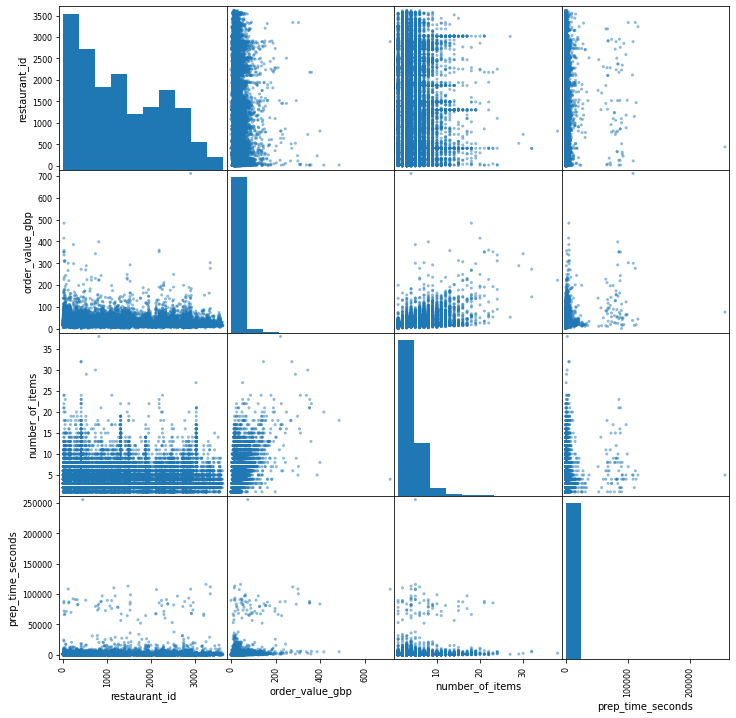

In [9]:
# Take a look at how our numerical features relate to each others (including target: prep_time_seconds)
display(data.corr())

pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

* order_value_gbp and number_of_items are the most correlated variables, their correlation makes sense.
* order_value_gbp and prep_time_seconds are the second most correlated varaiables.
* Still, these correlation coefficients are moderate if not weak.
* Several restaurants have distinctively higher range of number_of_items than that of others
* Now it is clearly seen that prep_time_seconds has two clusters. We can name it outliers vs non-outliers.
    * It can be used to generate synthetic data. 
    * Oversampling the `non-outliers` might produce a better training data, especially for predicting high preparation times.

* Presumably, order preparation duration is  dependent on busy hours of restaurants.
* We will derive several time features from `order_acknowledged_at` column

In [10]:
data = pd.merge(restaurant, order)
data.head(2)

,restaurant_id,country,city,type_of_food,order_acknowledged_at,order_ready_at,order_value_gbp,number_of_items,prep_time_seconds
0,3,UK,London,thai,2015-06-01 21:27:40.365042+01:00,2015-06-01 21:48:46.831010+01:00,34.8,4,1266
1,3,UK,London,thai,2015-06-01 21:31:44.126128+01:00,2015-06-01 21:48:41.336221+01:00,140.3,11,1017


In [11]:
data['order_acknowledged_at'] = pd.to_datetime(data['order_acknowledged_at'].apply(lambda x: x.split('+')[0]))
data['day'] = data['order_acknowledged_at'].dt.dayofweek
data['hour'] = data['order_acknowledged_at'].dt.hour

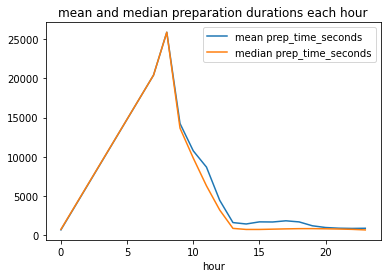

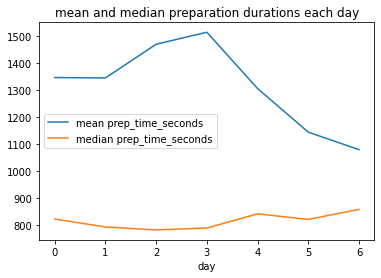

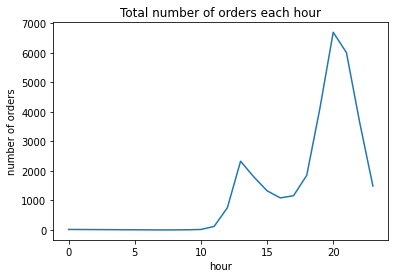

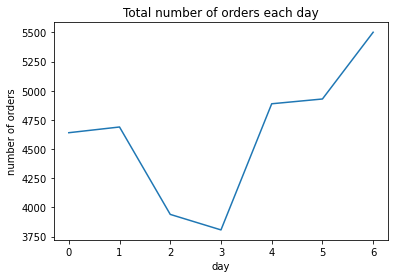

In [12]:
# mean and median preparation durations throughout day and week
for time_unit in ['hour','day']:
    data.groupby(time_unit)['prep_time_seconds'].mean().plot()
    data.groupby(time_unit)['prep_time_seconds'].median().plot()
    plt.legend(['mean prep_time_seconds','median prep_time_seconds'])
    plt.title(f'mean and median preparation durations each {time_unit}')
    plt.show()
    
# Total number of orders throughout day and week
for time_unit in ['hour','day']:
    data.groupby(time_unit)['prep_time_seconds'].count().plot(title=f'Total number of orders each {time_unit}')
    plt.ylabel('number of orders')
    plt.show()

* mean and median preparation durations seems like triangle function between hour = (0,12) and a small constant after that.
* Total number of orders each hour is bimodal with means at hour = 12 and 20
* Total number of orders dips in the middle of week

## 3 - Transformation

In [13]:
oencoder = OrdinalEncoder()

order = pd.read_csv('orders.csv.gz')
restaurant = pd.read_csv('restaurants.csv.gz') 
data = pd.merge(restaurant, order)

data = data.sort_values(['restaurant_id','order_acknowledged_at'])

for time_col in ['order_acknowledged_at', 'order_ready_at']:
    data[time_col] = pd.to_datetime(data[time_col].apply(lambda x: x.split('+')[0]))

categorical_col = data.select_dtypes(include=['object']).columns
categorical_col = ['restaurant_id'] + list(categorical_col) # also encode it
data.loc[:, categorical_col] = oencoder.fit_transform(data[categorical_col])

* We encoded categorical variables, as well as restaurant_id

In [14]:
def get_recent_preperation_status(time_window='50T'):
    
    list_completion_counts = []
    
    def calculate_preperation_status(x):
        
        if len(x)<2:
            list_completion_counts.append((0,0))
        else:
            window = restaurant_data.loc[x]
            last_order_acknowledged_at = window.loc[x[-1], 'order_acknowledged_at']
            window['completed'] = window['order_ready_at']<last_order_acknowledged_at
            all_but_last = window.iloc[:-1]['completed']
            num_completed = all_but_last.sum()
            num_incompleted = len(all_but_last)-num_completed
            list_completion_counts.append((num_completed, num_incompleted))

        # Return a dummy variable
        return 0

    for rid in data['restaurant_id'].unique():
        cols = ['order_acknowledged_at','order_ready_at']
        restaurant_data = data.loc[data['restaurant_id'] == rid, cols]
        assert restaurant_data['order_acknowledged_at'].is_monotonic_increasing
        index_series = (restaurant_data['order_acknowledged_at']
                       .reset_index()
                       .set_index('order_acknowledged_at'))
        
        index_series.rolling(time_window).apply(calculate_preperation_status, raw=True)

    preperation_status = pd.DataFrame(list_completion_counts, 
                                      columns=[f'num_completed_{time_window}', 
                                               f'num_incompleted_{time_window}'])
    
    return preperation_status

list_time_window = ['30T','45T','60T','90T']
list_recent_preperation_status = []

for time_window in list_time_window:
    list_recent_preperation_status.append(
        get_recent_preperation_status(time_window))

df_recent_preperation_status = pd.concat(list_recent_preperation_status, axis=1)
data = pd.concat([data, df_recent_preperation_status], axis=1)

* For each (restaurant,order) pair we included number of order statuses within different time windows
* Number of completed/incompleted orders within last 30, 40, 60, 90 minutes are added as new columns

In [15]:
data['day'] = data['order_acknowledged_at'].dt.dayofweek
data['hour'] = data['order_acknowledged_at'].dt.hour
data['day_sin'] = np.sin(2 * np.pi * data['day']/6.0)
data['day_cos'] = np.cos(2 * np.pi * data['day']/6.0)
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/23.0)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/23.0)

* Since time features are periodical, hours 0 and 23 are actually consecutive.
* To represent this information to our model, we do sin/cos transformations. 

In [16]:
for col in categorical_col:
    funcs = ['count', 'mean', 'median', 'min', 'max']
    grouped = (data
                .groupby(col)['prep_time_seconds']
                .agg(funcs)
                .reset_index())
    
    grouped.columns = [col] + [f'{func}_encoded_{col}' for func in funcs]
    data = pd.merge(data, grouped, how='left')

* We encode each categorical column by statistical properties
* Statistical properties 'count', 'mean', 'median', 'min', 'max'  are regarding the target variable
* This gives better results than plain ordinal encoding.

In [17]:
train, test = train_test_split(data, stratify=data['city'], random_state=44, test_size=0.1)

col_drop = ['order_acknowledged_at', 'order_ready_at']

train = train.drop(col_drop, axis=1)
test = test.drop(col_drop, axis=1)

mask = (train['prep_time_seconds']>=35)&(train['prep_time_seconds']<3050.35)
train = train[mask]

X_train = train.drop('prep_time_seconds', axis=1)
y_train = train['prep_time_seconds']
X_test = test.drop('prep_time_seconds', axis=1)
y_test = test['prep_time_seconds']

scaler = StandardScaler()
X_train.loc[:,:] = scaler.fit_transform(X_train)
X_test.loc[:,:] = scaler.transform(X_test)

model = XGBRegressor(seed = 44)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
analysis = pd.DataFrame({'y_true':y_test, 'y_pred':y_pred})

print('mse: {}'.format(mean_squared_error(analysis['y_true'], analysis['y_pred'])))
print('mae: {}'.format(mean_absolute_error(analysis['y_true'], analysis['y_pred'])))

#plt.scatter(analysis['y_true'], analysis['y_pred'])
#plt.show()

mse: 7613904.998853306
mae: 575.4558485078223


* We sampled train test sets by stratifying for city.
* This gives more reasonable representative sample than random sampling
* We eliminated outliers considering prep_time_seconds
* Scaler is needed for Support Vector Regressor
* scaler.fit_transform is used on train set
* scaler.transform is used on test set to avoid information leak

In [18]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 2]}
svr = SVR()

gridsearch_svr = GridSearchCV(svr, parameters, cv=3)
gridsearch_svr.fit(X_train, y_train)


parameters = {'reg_alpha': [0,0.5],
              'min_child_weight': [0,0.5],
              'subsample': [0.5,0.6, 0.7],
              'eta': [0.1],
              'n_estimators': [90,100]}

xgb = XGBRegressor(seed = 44)

gridsearch_xgb = GridSearchCV(xgb, parameters, cv=3)
gridsearch_xgb.fit(X_train, y_train)

def print_gridsearch_info(gridsearch, X_test, y_test):
    print(f'\nModel: {gridsearch.estimator.__class__}')
    print(f'best hyerparams: {gridsearch.best_params_}')
    print('Mean of mean fit time {:.3f}'.format(gridsearch.cv_results_['mean_fit_time'].mean()))
    print('Std of mean fit time {:.3f}'.format(gridsearch.cv_results_['mean_fit_time'].std()))
    print('Mean of mean score time {:.3f}'.format(gridsearch.cv_results_['mean_score_time'].mean()))
    print('Std of mean score time {:.3f}'.format(gridsearch.cv_results_['mean_score_time'].std()))
    
    y_pred = gridsearch.best_estimator_.predict(X_test)
    analysis = pd.DataFrame({'y_true':y_test, 'y_pred':y_pred})

    print('mse: {}'.format(mean_squared_error(analysis['y_true'], analysis['y_pred'])))
    print('mae: {}'.format(mean_absolute_error(analysis['y_true'], analysis['y_pred'])))
    
print_gridsearch_info(gridsearch_xgb, X_test, y_test)
print_gridsearch_info(gridsearch_svr, X_test, y_test)


Model: <class 'xgboost.sklearn.XGBRegressor'>
best hyerparams: {'eta': 0.1, 'min_child_weight': 0, 'n_estimators': 90, 'reg_alpha': 0.5, 'subsample': 0.7}
Mean of mean fit time 1.653
Std of mean fit time 0.108
Mean of mean score time 0.016
Std of mean score time 0.001
mse: 7612299.222722833
mae: 568.8749726943028

Model: <class 'sklearn.svm._classes.SVR'>
best hyerparams: {'C': 2, 'kernel': 'rbf'}
Mean of mean fit time 20.193
Std of mean fit time 3.395
Mean of mean score time 20.698
Std of mean score time 14.367
mse: 7912489.912206956
mae: 632.3541401719393


* To look for an alternative model, we also trained Support Vector Regression
* To avoid overfitting, we applied cross validation
    * Due to time and computing restrictions we settle for 3-fold cv
* We also tried different hyperparameters for optimizing each model.
    * For a reference of the most important XGboost hyperparameters,
      please see: https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html
* Notice that hp-optimized XGB model's mean absolute error is reduced from 575.4558 to 568.874. However, mean squared error is not significantly reduced.
* Training and Prediction times of XGB and SVR models are noticeably different.
    * Here XGB model is not only better in terms of prediction sucess;
    * but also better for reducing real-time prediction latency as well as reducing training cost.